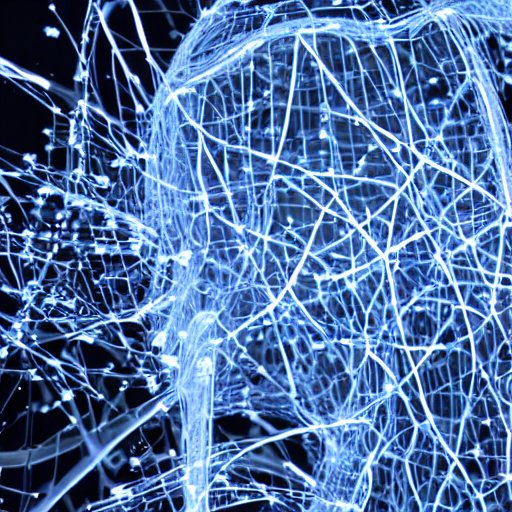

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(set("".join(words)))
stoi = {chars[i]:i+1 for i in range(len(chars))}
stoi['.'] = 0
itos = {i:c for c,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [3]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []
    i = 0
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            i += 1
            #if i < 32:
            # print (f'{i:02d}  ',"".join([itos[x] for x in context]), '--->', itos[ix])
            context = context[1:] + [ix] # crop 1 and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

len(Xtr), len(Xdev), len(Xte)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


(182625, 22655, 22866)

In [4]:
import torch

class Linear:   
    def __init__(self, fan_in, fan_out, bias, generator):
        # generator?
        self.weight = torch.randn((fan_in, fan_out), generator=generator) / fan_in **0.5
        self.bias = torch.zeros((fan_out,)) if bias else None    
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    def __repr__(self):
        x = self.weight.shape
        params = sum(p.nelement() for p in self.parameters()) 
        return f"Linear ({x[0]} inputs, {x[1]} outputs, {params} params)"
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.training = True
        self.eps = eps # avoids divide by zero
        self.momentum = momentum
        # gain
        self.gamma = torch.ones((1, dim))
        # bias
        self.beta = torch.zeros((1, dim))
        # buffers (momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # batch normalization, scale and shift
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                # adjust running mean towards batch mean
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_xvar = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
    def __repr__(self):
        return f'BatchNorm1d ({self.gamma.shape[1]} inputs, {self.eps} eps {self.momentum} momentum)'

class Tanh:    
    def __init__(self):
        pass
        
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def __repr__(self):
        return f'Tanh'
    
    def parameters(self):
        return []


# block_size and vocab_size see above
n_embd = 10 # char space dimensions
n_hidden = 100 # neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
b = False
layers = [
    Linear(block_size * n_embd, n_hidden, bias=b, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=b, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=b, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=b, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=b, generator=g), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=b, generator=g), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer less confident
    # layers[-1].weight *= 0.1  # not good with batch norm
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # fight the squashing function of tanh layers
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('nb of parameters:',sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

nb of parameters: 47551


In [30]:
max_step = 200000
batch_size = 32
lossi = []  # loss at every step (log10)
ud = []     # update to data ratio

for i in range(max_step):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate
    for layer in layers:
        x = layer(x)
    # loss
    loss = F.cross_entropy(x, Yb)
    # backward
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None # initialize gradients
    loss.backward()
    # update
    lr = 0.001 if i < 100000 else 0.0001
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 10000 == 0 or  i == max_step-1:
        print(f'{i:7d}/{max_step:7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([lr * p.grad.std() / p.data.std().log10().item() for p in parameters])
    if i > 1000:
        break

      0/ 200000 2.6903


In [31]:
# type of layer we want to visualize
target = Tanh  
# target = Linear

layer 2 (Tanh) | mean -0.01 | std +0.69 | saturated: 14.53%
layer 5 (Tanh) | mean -0.02 | std +0.73 | saturated: 17.25%
layer 8 (Tanh) | mean -0.00 | std +0.75 | saturated: 16.03%
layer 11 (Tanh) | mean +0.02 | std +0.75 | saturated: 17.25%
layer 14 (Tanh) | mean -0.02 | std +0.77 | saturated: 18.81%


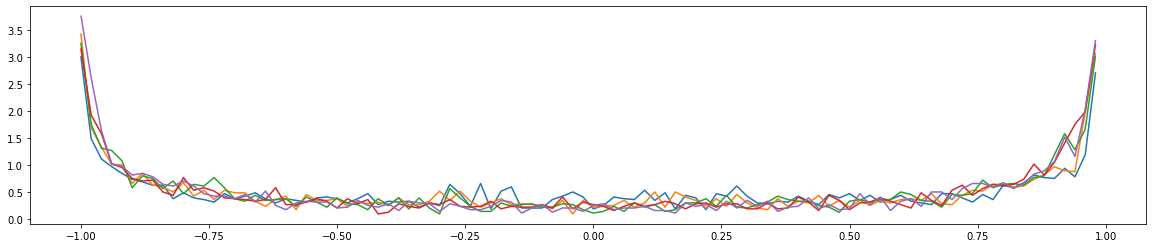

In [32]:
# outputs viz!
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, target):
        t = layer.out
        name = layer.__class__.__name__
        saturation = ((t.abs() > 0.97).float().mean() * 100).item()
        print('layer %d (%.10s) | mean %+.2f | std %+.2f | saturated: %.2f%%' %
             ( i,        name,   t.mean(),   t.std(),   saturation ) )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

torch.Size([32, 100])
layer 2 (Tanh) | mean +0.00 | std +0.00
torch.Size([32, 100])
layer 5 (Tanh) | mean +0.00 | std +0.00
torch.Size([32, 100])
layer 8 (Tanh) | mean -0.00 | std +0.00
torch.Size([32, 100])
layer 11 (Tanh) | mean +0.00 | std +0.00
torch.Size([32, 100])
layer 14 (Tanh) | mean +0.00 | std +0.00


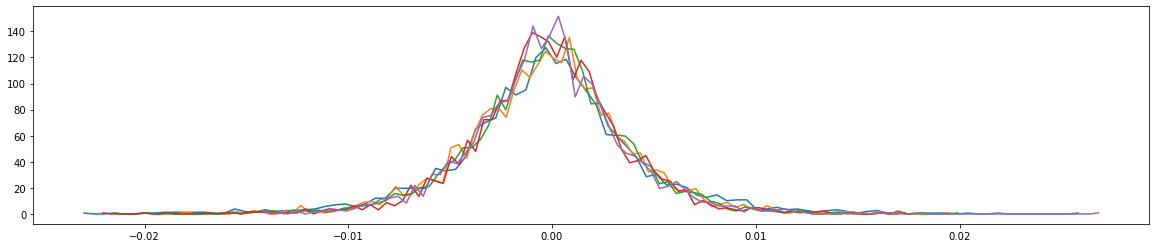

In [33]:
# gradients
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude output layer
    #print(i)
    if isinstance(layer, target):
        #print(layer)
        print(layer.out.shape)
        
        name = layer.__class__.__name__
        t = layer.out.grad
        assert(t is not None)
        print('layer %d (%.10s) | mean %+.2f | std %+.2f' %
             ( i,        name,   t.mean(),   t.std()) )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

weight torch.Size([27, 10]) | mean -0.000000 | std 1.889203e-02 | grad:data ratio 1.729470e-02
weight torch.Size([30, 100] | mean +0.000169 | std 8.738664e-03 | grad:data ratio 2.130990e-02
weight torch.Size([1, 100]) | mean -0.000006 | std 4.926182e-03 | grad:data ratio 3.530316e-02
weight torch.Size([1, 100]) | mean -0.000978 | std 8.126670e-03 | grad:data ratio 2.452291e-02
weight torch.Size([100, 100 | mean -0.000019 | std 5.774352e-03 | grad:data ratio 2.337794e-02
weight torch.Size([1, 100]) | mean +0.000069 | std 4.845808e-03 | grad:data ratio 3.686901e-02
weight torch.Size([1, 100]) | mean +0.000920 | std 6.857910e-03 | grad:data ratio 1.930497e-02
weight torch.Size([100, 100 | mean -0.000036 | std 5.835233e-03 | grad:data ratio 2.402117e-02
weight torch.Size([1, 100]) | mean -0.000023 | std 5.004095e-03 | grad:data ratio 3.998376e-02
weight torch.Size([1, 100]) | mean +0.001743 | std 8.589621e-03 | grad:data ratio 2.987476e-02
weight torch.Size([100, 100 | mean +0.000079 | std

Text(0.5, 1.0, 'Weights gradient distribution')

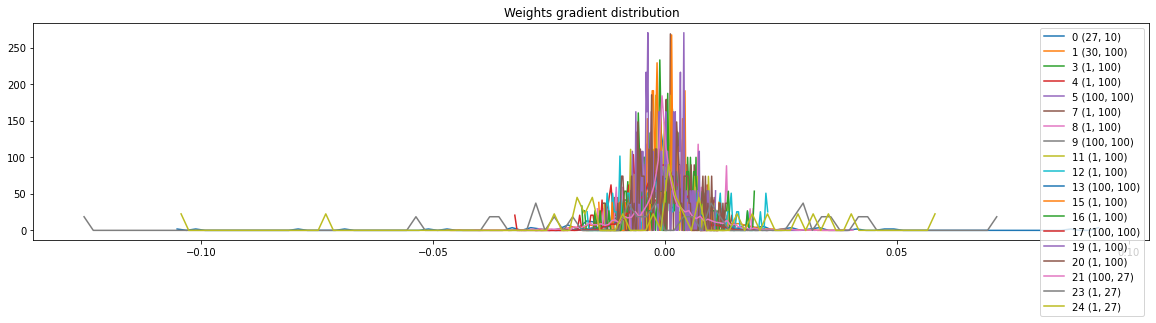

In [34]:
# gradient viz!
plt.figure(figsize=(20,4))
legends =[]
for i,p in enumerate(parameters):
    t = p.grad 
    if p.ndim == 2:
        print('weight %.20s | mean %+f | std %e | grad:data ratio %e' % 
              (p.shape,      t.mean(),  t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights gradient distribution')

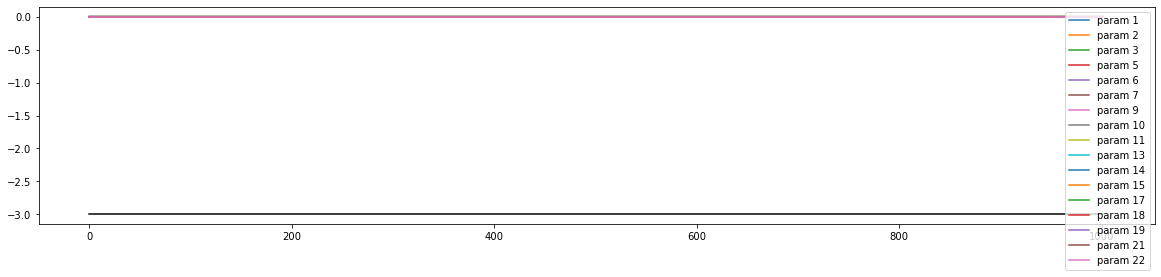

In [35]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters[2:]):
    if p.ndim == 2: # just the weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
# add grey line to show where things should stand        
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [36]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_emb)
    x = emb.view(emb.shape[0],-1) # concat into (N, block_size*n_emb)
    for layer in layers:
        x = layer(x)
    logits = x
    probs = F.softmax(logits, dim=1)
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item():.5f}')

split_loss('train')
split_loss('val')

train: 2.00898
val: 2.08227


In [37]:
def sample():
    out = []
    context = [0] * block_size
    ix = 0
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # add new letter we picked, discard oldest one
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    return ''.join(itos[i] for i in out)  

In [13]:
[sample() for _ in range(20)]

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0